Velocity data successfully extracted.
dthr (Range: max - min of hist): 1.1788
Velocity Threshold (90th percentile, from hist): 0.8014
Velocity Threshold (95th percentile, from hist): 0.8914

--- Velocity Risk Metrics ---

Velocity Threshold: 90th percentile (Value = 0.8014)
Historical Velocity:
  Normalized Intensity: 0.7700 ± 0.0006
  Exceedance Probability: 0.1000 ± 0.0008
  Hazard: 0.0770 ± 0.0006
Future SSP Velocity:
  Normalized Intensity: 0.7704 ± 0.0006
  Exceedance Probability: 0.1010 ± 0.0008
  Hazard: 0.0778 ± 0.0006

Velocity Threshold: 95th percentile (Value = 0.8914)
Historical Velocity:
  Normalized Intensity: 0.8253 ± 0.0007
  Exceedance Probability: 0.0500 ± 0.0006
  Hazard: 0.0412 ± 0.0005
Future SSP Velocity:
  Normalized Intensity: 0.8254 ± 0.0006
  Exceedance Probability: 0.0508 ± 0.0006
  Hazard: 0.0419 ± 0.0005

Return Level for T = 30 years:
  Historical: 0.9338 ± 0.0013
  Future SSP: 0.9359 ± 0.0015


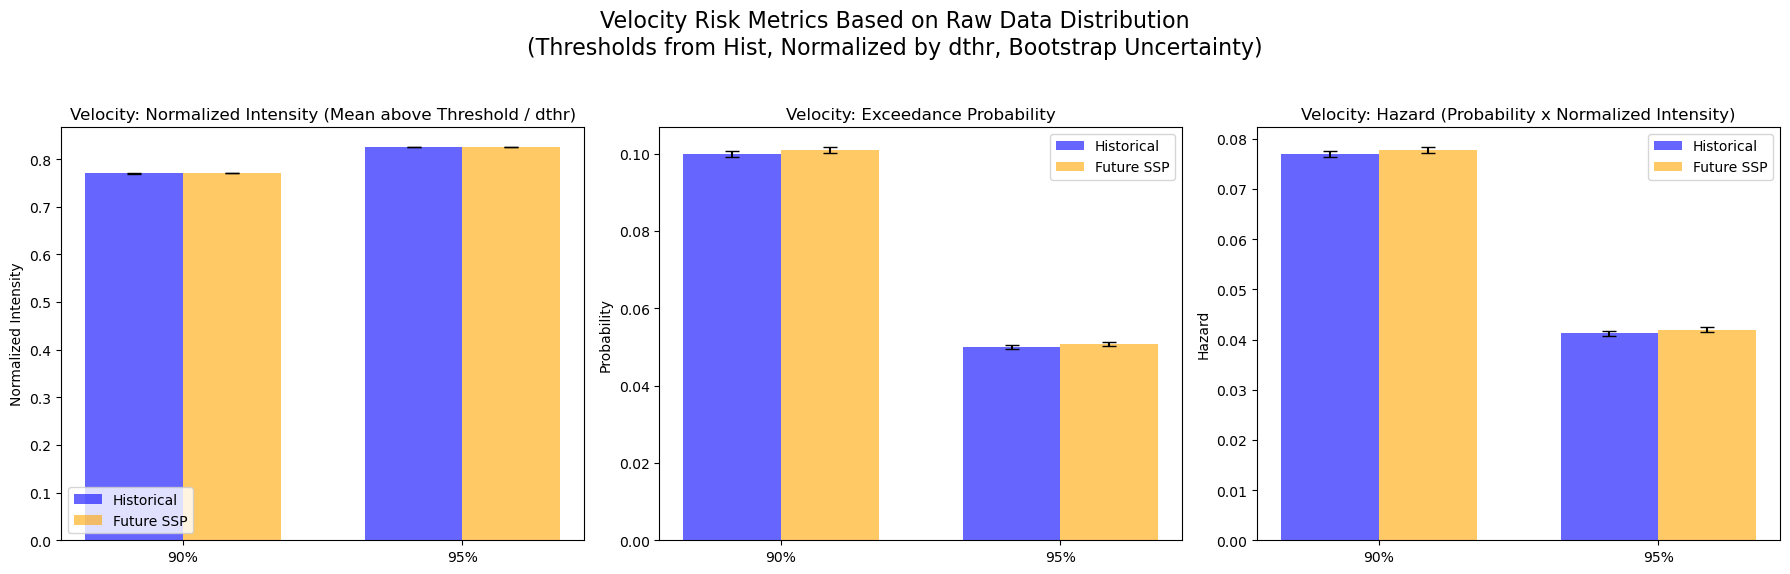


Return Level for T = 30 years:
  Historical: 0.9337 ± 0.0013
  Future SSP: 0.9358 ± 0.0016


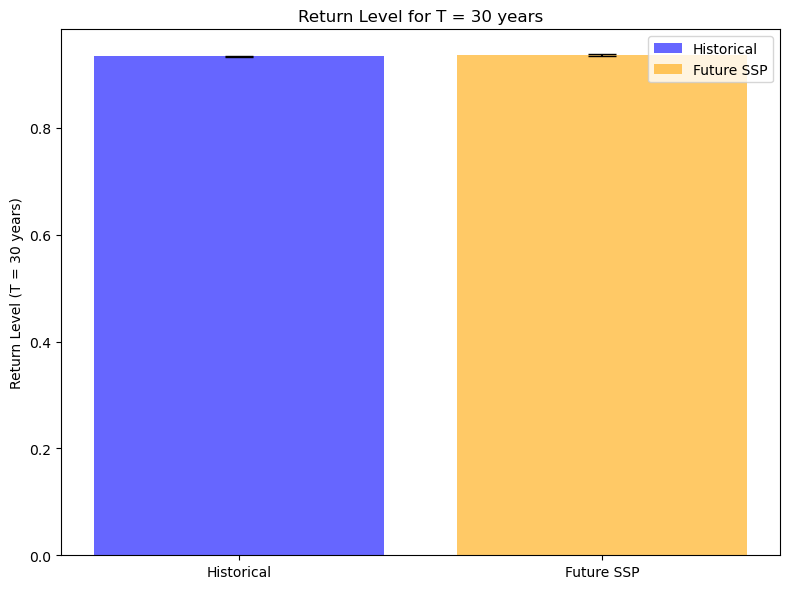

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Parameter Settings and Data Reading
# ------------------------------
outdir = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/"
ship = "gb"

# File paths for historical and Future SSP speederature data
file_hist = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/predicted_speed_hist_{ship}.nc"
file_ssp  = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/predicted_speed_ssp_{ship}.nc"

# Number of bootstrap iterations
n_bootstrap = 1000

# Read netCDF files
try:
    data_hist = xr.open_dataset(file_hist)
    data_ssp  = xr.open_dataset(file_ssp)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Extract speederature data (assumed variable name: 'predicted_speed_corrected')
try:
    speed_hist = data_hist['predicted_speed'].values.flatten()
    speed_ssp  = data_ssp['predicted_speed'].values.flatten()
    print("Velocity data successfully extracted.")
except KeyError as e:
    print(f"Error: Variable 'predicted_speed_corrected' not found in one of the datasets. {e}")
    exit()

# ------------------------------
# Define dthr from Historical Data as Range (100%-0%)
# ------------------------------
dthr = np.max(speed_hist) - np.min(speed_hist)
print(f"dthr (Range: max - min of hist): {dthr:.4f}")

# ------------------------------
# Define Metric Calculation Functions (with Normalization)
# ------------------------------
def calc_metrics(data, threshold, dthr):
    """
    Calculate risk metrics using the raw data distribution.
    
    :param data: 1D numpy array.
    :param threshold: Threshold value (set using historical data).
    :param dthr: The range (max - min) of the historical data for normalization.
    :return: (exceedance_prob, intensity, hazard)
             - exceedance_prob: fraction of data above threshold.
             - intensity: mean of data above threshold, normalized by dthr.
             - hazard: product of exceedance probability and normalized intensity.
    """
    mask = data > threshold
    n_total = len(data)
    n_exceed = np.sum(mask)
    if n_exceed == 0:
        return 0, np.nan, 0
    exceedance_prob = n_exceed / n_total
    if dthr == 0:
        intensity = np.nan
    else:
        intensity = np.mean(data[mask]) / dthr
    hazard = exceedance_prob * intensity
    return exceedance_prob, intensity, hazard

def bootstrap_metrics(data, threshold, dthr, n_bootstrap=1000):
    """
    Use bootstrap resampling to compute the distribution of risk metrics.
    Returns the mean and half the 95% CI width (symmetric error) for each metric.
    """
    boot_probs = []
    boot_intensities = []
    boot_hazards = []
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        prob, inten, haz = calc_metrics(sample, threshold, dthr)
        if np.isnan(inten):
            continue
        boot_probs.append(prob)
        boot_intensities.append(inten)
        boot_hazards.append(haz)
    if len(boot_probs) == 0:
        return (0, 0), (np.nan, 0), (0, 0)
    
    boot_probs = np.array(boot_probs)
    boot_intensities = np.array(boot_intensities)
    boot_hazards = np.array(boot_hazards)
    
    def summary(arr):
        mean_val = np.mean(arr)
        ci_lower = np.percentile(arr, 2.5)
        ci_upper = np.percentile(arr, 97.5)
        err = (ci_upper - ci_lower) / 2
        return mean_val, err

    return summary(boot_probs), summary(boot_intensities), summary(boot_hazards)

# ------------------------------
# Define Return Level Calculation Functions for T = 30 years
# ------------------------------
def calc_return_level(data, T):
    """
    Calculate the return level for a given return period T.
    Assumes the data are independent and the return level is the (1 - 1/T) quantile.
    
    :param data: 1D numpy array.
    :param T: Return period (years).
    :return: return level (quantile value)
    """
    quantile_level = (1 - 1/T) * 100
    return np.percentile(data, quantile_level)

def bootstrap_return_level(data, T, n_bootstrap=1000):
    """
    Use bootstrap resampling to compute the distribution of return levels for a given T.
    Returns the mean and half the 95% CI width (symmetric error) for the return level.
    """
    boot_levels = []
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        level = calc_return_level(sample, T)
        boot_levels.append(level)
    boot_levels = np.array(boot_levels)
    mean_level = np.mean(boot_levels)
    ci_lower = np.percentile(boot_levels, 2.5)
    ci_upper = np.percentile(boot_levels, 97.5)
    err = (ci_upper - ci_lower) / 2
    return mean_level, err

# ------------------------------
# Settings for Analysis (Thresholds)
# ------------------------------
threshold_percents = [90, 95]

results_speed = {
    'probability': {'hist': [], 'ssp': []},
    'intensity': {'hist': [], 'ssp': []},
    'hazard': {'hist': [], 'ssp': []},
    'thresholds': []  # actual threshold values (from historical speederature)
}

# ------------------------------
# Analysis for Velocity (Risk Metrics)
# ------------------------------
for perc in threshold_percents:
    thresh_value = np.percentile(speed_hist, perc)
    results_speed['thresholds'].append(thresh_value)
    print(f"Velocity Threshold ({perc}th percentile, from hist): {thresh_value:.4f}")
    
    # Historical speederature metrics
    prob_h, inten_h, haz_h = calc_metrics(speed_hist, thresh_value, dthr)
    (mean_prob_h, err_prob_h), (mean_inten_h, err_inten_h), (mean_haz_h, err_haz_h) = bootstrap_metrics(speed_hist, thresh_value, dthr, n_bootstrap)
    results_speed['probability']['hist'].append((mean_prob_h, err_prob_h))
    results_speed['intensity']['hist'].append((mean_inten_h, err_inten_h))
    results_speed['hazard']['hist'].append((mean_haz_h, err_haz_h))
    
    # Future SSP speederature metrics (using same threshold from hist)
    prob_s, inten_s, haz_s = calc_metrics(speed_ssp, thresh_value, dthr)
    (mean_prob_s, err_prob_s), (mean_inten_s, err_inten_s), (mean_haz_s, err_haz_s) = bootstrap_metrics(speed_ssp, thresh_value, dthr, n_bootstrap)
    results_speed['probability']['ssp'].append((mean_prob_s, err_prob_s))
    results_speed['intensity']['ssp'].append((mean_inten_s, err_inten_s))
    results_speed['hazard']['ssp'].append((mean_haz_s, err_haz_s))

print("\n--- Velocity Risk Metrics ---")
for i, perc in enumerate(threshold_percents):
    thresh_value = results_speed['thresholds'][i]
    print(f"\nVelocity Threshold: {perc}th percentile (Value = {thresh_value:.4f})")
    intensity_hist, intensity_hist_err = results_speed['intensity']['hist'][i]
    prob_hist, prob_hist_err = results_speed['probability']['hist'][i]
    hazard_hist, hazard_hist_err = results_speed['hazard']['hist'][i]
    print("Historical Velocity:")
    print(f"  Normalized Intensity: {intensity_hist:.4f} ± {intensity_hist_err:.4f}")
    print(f"  Exceedance Probability: {prob_hist:.4f} ± {prob_hist_err:.4f}")
    print(f"  Hazard: {hazard_hist:.4f} ± {hazard_hist_err:.4f}")
    
    intensity_ssp, intensity_ssp_err = results_speed['intensity']['ssp'][i]
    prob_ssp, prob_ssp_err = results_speed['probability']['ssp'][i]
    hazard_ssp, hazard_ssp_err = results_speed['hazard']['ssp'][i]
    print("Future SSP Velocity:")
    print(f"  Normalized Intensity: {intensity_ssp:.4f} ± {intensity_ssp_err:.4f}")
    print(f"  Exceedance Probability: {prob_ssp:.4f} ± {prob_ssp_err:.4f}")
    print(f"  Hazard: {hazard_ssp:.4f} ± {hazard_ssp_err:.4f}")

# ------------------------------
# Analysis for Velocity (Return Level for T = 30 years)
# ------------------------------
T = 30
return_level_hist, err_return_level_hist = bootstrap_return_level(speed_hist, T, n_bootstrap)
return_level_ssp, err_return_level_ssp = bootstrap_return_level(speed_ssp, T, n_bootstrap)
print(f"\nReturn Level for T = {T} years:")
print(f"  Historical: {return_level_hist:.4f} ± {err_return_level_hist:.4f}")
print(f"  Future SSP: {return_level_ssp:.4f} ± {err_return_level_ssp:.4f}")

# ------------------------------
# Prepare Data for Plotting (Replace NaNs with zeros)
# ------------------------------
def replace_nan(arr):
    return np.nan_to_num(arr, nan=0)

speed_labels = [f"{p}%" for p in threshold_percents]
x = np.arange(len(speed_labels))
width = 0.35

intensity_hist_means = replace_nan(np.array([val[0] for val in results_speed['intensity']['hist']]))
intensity_hist_errs = replace_nan(np.array([val[1] for val in results_speed['intensity']['hist']]))
intensity_ssp_means = replace_nan(np.array([val[0] for val in results_speed['intensity']['ssp']]))
intensity_ssp_errs = replace_nan(np.array([val[1] for val in results_speed['intensity']['ssp']]))

prob_hist_means = replace_nan(np.array([val[0] for val in results_speed['probability']['hist']]))
prob_hist_errs = replace_nan(np.array([val[1] for val in results_speed['probability']['hist']]))
prob_ssp_means = replace_nan(np.array([val[0] for val in results_speed['probability']['ssp']]))
prob_ssp_errs = replace_nan(np.array([val[1] for val in results_speed['probability']['ssp']]))

hazard_hist_means = replace_nan(np.array([val[0] for val in results_speed['hazard']['hist']]))
hazard_hist_errs = replace_nan(np.array([val[1] for val in results_speed['hazard']['hist']]))
hazard_ssp_means = replace_nan(np.array([val[0] for val in results_speed['hazard']['ssp']]))
hazard_ssp_errs = replace_nan(np.array([val[1] for val in results_speed['hazard']['ssp']]))

# ------------------------------
# Plot Bar Charts for Velocity Risk Metrics (Separate Panels)
# ------------------------------
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].bar(x - width/2, intensity_hist_means, width, yerr=intensity_hist_errs, capsize=5, label='Historical', color='blue', alpha=0.6)
axes[0].bar(x + width/2, intensity_ssp_means, width, yerr=intensity_ssp_errs, capsize=5, label='Future SSP', color='orange', alpha=0.6)
axes[0].set_title("Velocity: Normalized Intensity (Mean above Threshold / dthr)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(speed_labels)
axes[0].set_ylabel("Normalized Intensity")
axes[0].legend()

axes[1].bar(x - width/2, prob_hist_means, width, yerr=prob_hist_errs, capsize=5, label='Historical', color='blue', alpha=0.6)
axes[1].bar(x + width/2, prob_ssp_means, width, yerr=prob_ssp_errs, capsize=5, label='Future SSP', color='orange', alpha=0.6)
axes[1].set_title("Velocity: Exceedance Probability")
axes[1].set_xticks(x)
axes[1].set_xticklabels(speed_labels)
axes[1].set_ylabel("Probability")
axes[1].legend()

axes[2].bar(x - width/2, hazard_hist_means, width, yerr=hazard_hist_errs, capsize=5, label='Historical', color='blue', alpha=0.6)
axes[2].bar(x + width/2, hazard_ssp_means, width, yerr=hazard_ssp_errs, capsize=5, label='Future SSP', color='orange', alpha=0.6)
axes[2].set_title("Velocity: Hazard (Probability x Normalized Intensity)")
axes[2].set_xticks(x)
axes[2].set_xticklabels(speed_labels)
axes[2].set_ylabel("Hazard")
axes[2].legend()

plt.suptitle("Velocity Risk Metrics Based on Raw Data Distribution\n(Thresholds from Hist, Normalized by dthr, Bootstrap Uncertainty)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ------------------------------
# Plot Return Level for T = 30 years
# ------------------------------
T = 30
ret_level_hist, err_ret_level_hist = bootstrap_return_level(speed_hist, T, n_bootstrap)
ret_level_ssp, err_ret_level_ssp = bootstrap_return_level(speed_ssp, T, n_bootstrap)

print(f"\nReturn Level for T = {T} years:")
print(f"  Historical: {ret_level_hist:.4f} ± {err_ret_level_hist:.4f}")
print(f"  Future SSP: {ret_level_ssp:.4f} ± {err_ret_level_ssp:.4f}")

fig_rl, ax_rl = plt.subplots(figsize=(8, 6))
ax_rl.bar(0, ret_level_hist, yerr=err_ret_level_hist, capsize=10, label='Historical', color='blue', alpha=0.6)
ax_rl.bar(1, ret_level_ssp, yerr=err_ret_level_ssp, capsize=10, label='Future SSP', color='orange', alpha=0.6)
ax_rl.set_xticks([0, 1])
ax_rl.set_xticklabels(['Historical', 'Future SSP'])
ax_rl.set_ylabel("Return Level (T = 30 years)")
ax_rl.set_title("Return Level for T = 30 years")
ax_rl.legend()
plt.tight_layout()
plt.show()
